In [1]:
import pandas as pd
import datetime
import numpy as np
import tensorflow as tf

# グラフ描画
from matplotlib import pylab as plt

# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
from oanda_utils import load_assign_dtype

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
df_m = load_assign_dtype("data/usd_jpy_m1.csv")
df_h = load_assign_dtype("data/usd_jpy_h1.csv")
df_d = load_assign_dtype("data/usd_jpy_d.csv")

In [5]:
target_window = 60
train_mins = 480

x_list = []
y_list = []
cnt = 0

for target_time in df_m['time'][train_mins:-target_window]:

    to_minute = target_time
    to_hour = target_time - datetime.timedelta(minutes = target_time.minute)
    to_date = target_time -  datetime.timedelta(days=1, minutes = target_time.minute, hours = target_time.hour)

    m_cond = (df_m['time']  < to_minute) 
    h_cond =  (df_h['time']  < to_hour) 
    d_cond = (df_d['time'] < to_date)

    df_m_target = df_m[m_cond][-train_mins:]
    df_h_target = df_h[h_cond][-24:]
    df_d_target = df_d[d_cond][-20:]

    df_target = pd.concat([df_d_target, df_h_target, df_m_target])
#     if df_target.shape != (104, 7):
#         cnt += 1
#         print(target_time, df_target.shape, cnt)
#         continue
    x_list.append(df_target[['O', 'H', 'L', 'C']].values[np.newaxis, :, :])
    y_list.append(df_m[~m_cond][:target_window]['C'].values[np.newaxis, :])

In [6]:
X = np.vstack(x_list)
y = np.vstack(y_list)

In [7]:
def standard(arr):
    
    mean =  arr.mean()
    std =  arr.std()
    adj = (arr - mean) / std
    
    return mean, std, adj

In [8]:
mean_open, std_open, X[:, :, 0] = standard(X[:, :, 0])
mean_high, std_high, X[:, :, 1]= standard(X[:, :, 1])
mean_low, std_low, X[:, :, 2] = standard(X[:, :, 2])
mean_close, std_close, X[:, :, 3] = standard(X[:, :, 3])

In [9]:
y = (y - mean_close) / std_close

In [10]:
val_num = 200
test_num = 100

X_train = X[:-(test_num+target_window)][:-val_num]
X_val = X[:-(test_num+target_window)][-val_num:]
X_test = X[-test_num:]

y_train = y[:-(test_num+target_window)][:-val_num]
y_val = y[:-(test_num+target_window)][-val_num:]
y_test = y[-test_num:]

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(1000, activation='tanh', input_shape=(None, 4)),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(target_window)
])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError())

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1000)              4020000   
_________________________________________________________________
dense (Dense)                (None, 100)               100100    
_________________________________________________________________
dense_1 (Dense)              (None, 60)                6060      
Total params: 4,126,160
Trainable params: 4,126,160
Non-trainable params: 0
_________________________________________________________________


In [13]:
batch_size = 200
n_epoch = 500

# 学習
hist = model.fit(X_train, y_train,
                 epochs=n_epoch,
                 validation_data=(X_val, y_val),
                 verbose=1,
                 batch_size=batch_size)

Epoch 1/500
21/21 [==============================] - 157s 7s/step - loss: 0.3739 - val_loss: 0.0405
Epoch 2/500
21/21 [==============================] - 158s 8s/step - loss: 0.0516 - val_loss: 0.1006
Epoch 3/500
21/21 [==============================] - 156s 7s/step - loss: 0.0439 - val_loss: 0.0677
Epoch 4/500
21/21 [==============================] - 155s 7s/step - loss: 0.0457 - val_loss: 0.0436
Epoch 5/500
21/21 [==============================] - 156s 7s/step - loss: 0.0411 - val_loss: 0.0721
Epoch 6/500
21/21 [==============================] - 156s 7s/step - loss: 0.0373 - val_loss: 0.0932
Epoch 7/500
21/21 [==============================] - 156s 7s/step - loss: 0.0389 - val_loss: 0.0628
Epoch 8/500
21/21 [==============================] - 156s 7s/step - loss: 0.0431 - val_loss: 0.1275
Epoch 9/500
18/21 [========================>.....] - ETA: 22s - loss: 0.0368

KeyboardInterrupt: 

In [ ]:
plt.plot(hist.history['loss'],label="train set")
plt.plot(hist.history['val_loss'],label="val set")
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
# plt.ylim(0, 0.002)
plt.legend()
plt.show()

In [14]:
y_stack  = model.predict(X_test)
y_stack = std_close * y_stack + mean_close
y_raw = std_close * y_test + mean_close

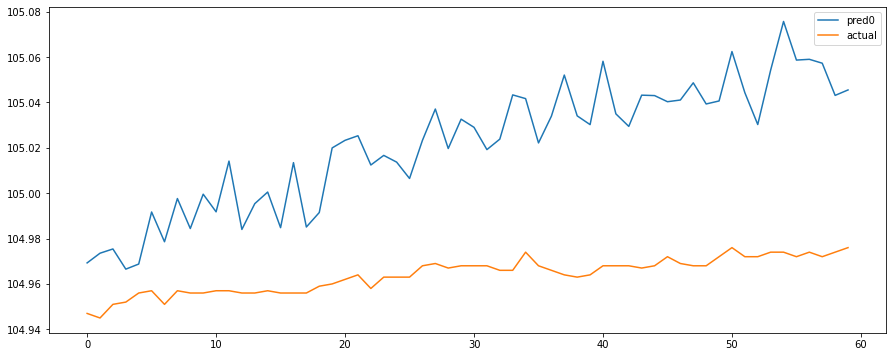

In [16]:
pd.Series(y_stack[0, :]).plot(label='pred0')

pd.Series(y_raw[0, :]).plot(label='actual')
plt.legend()
# plt.xlim(400, 500)
plt.show()

In [ ]:
y_raw